# Notebook: histoRAG
This notebook contains the code for building a Retrieval Augmented Generation Model for contemporary history. In principle, it follows the structure of [LangChain docs](https://python.langchain.com/docs/expression_language/cookbook/retrieval#conversational-retrieval-chain) using the LangChain Expression Language (LCEL) and conversation history.

# 0. Install libraries

In [ ]:
!pip install -qU openai cohere faiss-cpu langchain langchain-community tiktoken==0.5.2 langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

# 1. Create a vectorstore
A vector store is neccessary for the retrieval part of the model. This consists of text parts from the fed-in sources and later serves as a knowledge base for the retriever.

In [ ]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the next step, an embedding model is initiated (here: `text-embedding-ada-002` from [OpenAI](https://openai.com/blog/new-and-improved-embedding-model)).

In [ ]:
# setup embedding model
import os
from getpass import getpass
from langchain_openai import OpenAIEmbeddings

secret = getpass("Enter your OpenAI API key: ")
OPENAI_API_KEY = secret
model_name = 'text-embedding-ada-002'

embeddings = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

## A. Build a new index
When sources are used for the first time, the vector store is newly created. To do this, the text file is first read in and then split into chunks.

In [ ]:
# # path to folder containing the .txt files
# folder_path = "../data/source_documents_TXT"

# # Key: file name, Value: file content
# data = {}

# # iterate through all files
# for file_name in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, file_name)
#     with open(file_path, 'r', encoding='utf-8') as file:
#         data[file_name] = file.read()

In [ ]:
# from langchain.text_splitter import CharacterTextSplitter

# text_splitter = CharacterTextSplitter(chunk_size = 1000, chunk_overlap=200, separator='')

In [ ]:
# # build the docs from the file dict
# docs = []

# # lists for texts and their corresponding metadata
# texts = []
# metadatas = []

# # iterate over each file and its content in the data dict
# for file_name, text_content in data.items():
#     # add content
#     texts.append(text_content)
#     # create a metadata dict and add it
#     metadatas.append({'filename': file_name})

# # create docs
# docs = text_splitter.create_documents(texts, metadatas)

In [ ]:
# # did it work?
# print(docs[3], '\n', docs[7])

page_content='lassenheit der Zukunft gegenüber.\n\nDas trifft den einen weniger, die anderen mehr und viele mit der ganzen furchtbaren Wucht. In einem seid ihr aber alle reich geworden: reich an Sorge. O diese große tägliche und nächtliche Sorge bei so großer Armut!\n\nDer Grund\n\nIch stocke wieder. Ich blicke zu meinen Kameraden hinüber, ihre behelmten Stirnen scheinen mir nicht zuzunicken, die starken Augen unter dem Helmrand scheinen zu sagen: Vergiss das Beste nicht, Kamerad!\n\nWollt ihr mir folgen, ihr Frauen und Mädchen, zu dem was wir das Beste nennen, auf den Grund, auf den tiefsten Grund hinunter? Wenn ihr ein Korn in die Erde sät, was ist es doch für ein armes Korn in der großen, fremden Erde! Das ganz Andere umgibt es und deckt es zu. Ist es nicht dem Vergehen ausgesetzt? Aber das kleine Korn ist ganz gesammelt in sich, es hat nur sich selbst, es birgt etwas, birgt den zartesten Lebensfunken in seiner spröden Schale. Es birgt das Beste der oberen Welt zurückgezogen in sich

**Note**: The CharacterTextSplitter is a very simple type of splitting. Other options are:
- SemanticChunker:
  https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker
- ParentDocument retriever: https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever; https://www.youtube.com/watch?v=07H-om5lj-s&t=131s


Using the embedding model, the individual chunks are converted into embeddings and loaded into a [FAISS](https://faiss.ai/index.html) store using [LangChain](https://python.langchain.com/docs/integrations/vectorstores/faiss).

In [ ]:
# # setup FAISS store
# from langchain.vectorstores import FAISS

# # storing embeddings in the vector store
# vectorstore = FAISS.from_documents(docs, embeddings)

.. and saved locally:

In [ ]:
# # save FAISS locally
# vectorstore.save_local("../data/eval_datasets/faiss_index_FW_2")

## B. Connect to existing index
If an index already exists with the sources we want to work with, this can be loaded from the memory.

In [ ]:
from langchain.vectorstores import FAISS

vectorstore = FAISS.load_local("../data/eval_datasets/faiss_index_FW_2", embeddings, allow_dangerous_deserialization=True)

---

## Querying
To test whether the vector store is working properly, we run a test with the question "Was will Friederike mit ihrer Freundin Gudrun machen?" (What does Friederike want to do with her friend Gudrun?). Both are characters from the "Menschenwende" novel published by Frauen-Warte in 1935.

In [ ]:
query = "Was will Friederike mit ihrer Freundin Gudrun machen?"

vectorstore.similarity_search(
    query,
    k=3
)

[Document(page_content='t ein selbstverständliches Verhältnis herstellte. Die zweite Mutter jedoch vermochte der Seele des Mädchens nicht nahe zu kommen.\n\nNun, im Sommer 1914, war Friederike zwanzig Jahre alt. Zu dieser Zeit erwachte in ihr der Wunsch, einmal eine selbständige Reise ganz ohne ihre Familie zu machen. Sie wollte sich mit ihrer Freundin Gudrun von Falkenthal, die in Freiburg im Breisgau Medizin studierte, treffen, um von dort im Schwarzwald zu wandern.\n\nAls Friederike in Freiburg ankam, sprang sie aus dem Zug, um der Freundin entgegenzueilen. „Oh du, du, wie schön, dass wir endlich wieder beieinander sind!"\n\nDie jungen Mädchen gingen fröhlich durch die Stadt. Gudrun lebte im Studentenstübchen, in dem auch Friederike in den Freiburger Tagen ihre Stätte haben sollte. Gudrun wollte der Freundin jedoch mit stolzem Eifer einiges Großartige von Freiburg und ihrem Leben dort zeigen. Sie durchschritten den alten Karlsfriedhof, der sich nun in einen Spazierpark voll träumend

# 2. Build the RAG model
The RAG model will be built next. A workflow is defined using [LangChain](https://python.langchain.com/docs/get_started/introduction).

First, the vectorstore created above is initialised as a retriever.

To include the dialogue story in the chat, a prompt template is defined and converted into a `PromptTemplate` object. In this template, the dialogue history is merged with the current question.

In [ ]:
from langchain.prompts.prompt import PromptTemplate

retriever = vectorstore.as_retriever()

_template = """Formuliere den folgenden Dialog und die follow-up Frage so um, dass sie eine eigenständige Frage ist, und zwar in der Originalsprache.

Dialoggeschichte:
{chat_history}
follow-up Frage: {question}
eigenständige Frage:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In a further prompt, the context (the documents retrieved from the KB) is summarised in an instruction with the query in order to be transferred together to the LLM, that gives the final answer.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

template = """Beantworte die Frage basierend alleinig auf dem folgenden Kontext:
{context}

Frage: {question}
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(template)

For the `context` variable, we need the content of the retrieved documents as text. To do this, we write a function that takes the documents, a template to get the `page_content` and a separator and returns the joined texts.

In [ ]:
from langchain.schema import format_document

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")

def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

### Now we put the chain together (fist with an empty `chat_history`).
Docs for the used Runnables:
- [RunnableParallel](https://python.langchain.com/docs/expression_language/how_to/map)
- [RunnablePassthrough](https://python.langchain.com/docs/expression_language/how_to/passthrough)

**1. Integrate the dialog history with `_inputs`:**  
- `RunnableParallel()` manipulates the output so that it fits as input into the next runnable of the sequence (here: `CONDENSE_QUESTION_PROMPT`)
- `RunnablePassthrough()` is used to pass the `chat_history` to the input as a further argument
- the `CONDENSE_QUESTION_PROMPT` applies the template defined above
- this is sent to `ChatOpenAI()`
- the output is formatted as a string with `StrOutputParser()`

**2. Build `_context` from:**
1. The documents that are found with the retriever. The search input for this is the `standalone_question`.
> `itemgetter` is a shorthand to extract data from the map (see [Python Docu](https://docs.python.org/3/library/operator.html#operator.itemgetter)).
2. And `question`, which was converted to the `standalone_question` together with the dialogue history.


**3. Put the `conversational_qa_chain` together from:**
- `_inputs`
- `_context`
- the `ANSWER_PROMPT` from above
- and the LLM to which all the information in this prompt is passed.


In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

_inputs = RunnableParallel(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: get_buffer_string(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(openai_api_key=OPENAI_API_KEY, temperature=0)
    | StrOutputParser(),
)
_context = {
    "context": itemgetter("standalone_question") | retriever | _combine_documents,
    "question": lambda x: x["standalone_question"],
}
conversational_qa_chain = _inputs | _context | ANSWER_PROMPT | ChatOpenAI(openai_api_key=OPENAI_API_KEY)

We start the chain with a question and an initially empty chat history:

In [ ]:
conversational_qa_chain.invoke(
    {
        "question": "Was will Friederike mit ihrer Freundin Gudrun machen?",
        "chat_history": []
    }
)

AIMessage(content='Friederike möchte sich mit ihrer Freundin Gudrun von Falkenthal treffen, um im Schwarzwald zu wandern.', response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 1194, 'total_tokens': 1221}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None}, id='run-d481f5c6-8b49-479b-9e30-6c52355a7628-0')

Looks good! Now let's add the actual chat_history to the chain:

In [ ]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    return_messages=True, output_key="answer", input_key="question"
)

In [ ]:
print(memory)

output_key='answer' input_key='question' return_messages=True


The final chain is assembled.
Docs for the runnables:
[RunnableLambda](https://python.langchain.com/docs/expression_language/how_to/functions)
1. We add one step to `loaded_memory` and add the **history**.
2. `standalone_question` is formed using the current `question` and `chat_history`, both sent to the LLM with the `CONDENSE_QUESTION_PROMPT`.
3. Retrieve the documents with the `standalone_question` and the retriever.
4. Assemble the inputs for the `ANSWER_PROMPT`.
5. Define the answer as the output of the LLM to the `ANSWER_PROMPT` plus the documents used.
6. Put everything together in a final chain.

In [ ]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# 1. add memory
loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)

# 2. calc the standalone_question
standalone_question = {
    "standalone_question": {
        "question": lambda x: x["question"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(openai_api_key=OPENAI_API_KEY, temperature=0)
    | StrOutputParser(),
}

# 3. retrieve the docs
retrieved_documents = {
    "docs": itemgetter("standalone_question") | retriever,
    "question": lambda x: x["standalone_question"],
}

# 4. put the final_inputs together
final_inputs = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": itemgetter("question"),
}

# 5. define answer structure
answer = {
    "answer": final_inputs | ANSWER_PROMPT | ChatOpenAI(openai_api_key=OPENAI_API_KEY),
    "docs": itemgetter("docs"),
}

# 6. put everything together
final_chain = loaded_memory | standalone_question | retrieved_documents | answer

Let's test it

In [ ]:
inputs = {"question": "Was will Friederike mit ihrer Freundin Gudrun machen?"}
result = final_chain.invoke(inputs)
result

{'answer': AIMessage(content='Friederike und ihre Freundin Gudrun planen, sich in Freiburg zu treffen, um gemeinsam im Schwarzwald zu wandern.', response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 1215, 'total_tokens': 1248}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None}, id='run-e03dd9db-fede-4adc-aab1-c1bf0eff6548-0'),
 'docs': [Document(page_content='t ein selbstverständliches Verhältnis herstellte. Die zweite Mutter jedoch vermochte der Seele des Mädchens nicht nahe zu kommen.\n\nNun, im Sommer 1914, war Friederike zwanzig Jahre alt. Zu dieser Zeit erwachte in ihr der Wunsch, einmal eine selbständige Reise ganz ohne ihre Familie zu machen. Sie wollte sich mit ihrer Freundin Gudrun von Falkenthal, die in Freiburg im Breisgau Medizin studierte, treffen, um von dort im Schwarzwald zu wandern.\n\nAls Friederike in Freiburg ankam, sprang sie aus dem Zug, um der Freundin entgegenzueilen. „Oh du, d

It works!
As memory does not save automatically, we have to add this step after each turn:

In [ ]:
memory.save_context(inputs, {"answer": result["answer"].content})

## Check the memory
Test: whats the dialog history?

In [ ]:
# check the saved memory
memory.load_memory_variables({})

{'history': [HumanMessage(content='Was will Friederike mit ihrer Freundin Gudrun machen?'),
  AIMessage(content='Friederike und ihre Freundin Gudrun planen, sich in Freiburg zu treffen, um gemeinsam im Schwarzwald zu wandern.')]}

In [ ]:
inputs = {"question": "Was erleben sie auf ihrem Ausflug?"}
result = final_chain.invoke(inputs)
result

{'answer': AIMessage(content='Friederike und Gudrun erkunden die Stadt Freiburg, besuchen den alten Karlsfriedhof, steigen zum Schloßberg hinauf, essen in einer Wirtschaft am Ufer und genießen den Ausblick über die Stadt. Sie erleben eine angenehme Sommernacht und beobachten die Stadt im festlichen Lichterschmuck.', response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1210, 'total_tokens': 1292}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None}, id='run-db3f6a06-5ef7-4782-8d40-55689a923cfc-0'),
 'docs': [Document(page_content='t ein selbstverständliches Verhältnis herstellte. Die zweite Mutter jedoch vermochte der Seele des Mädchens nicht nahe zu kommen.\n\nNun, im Sommer 1914, war Friederike zwanzig Jahre alt. Zu dieser Zeit erwachte in ihr der Wunsch, einmal eine selbständige Reise ganz ohne ihre Familie zu machen. Sie wollte sich mit ihrer Freundin Gudrun von Falkenthal, die in Freiburg im Breisg

---
# 3. Evaluation with RAGAS
Tutorial: [AI Makerspace / YT ](https://www.youtube.com/watch?v=mEv-2Xnb_Wk)

Doku: [RAGAS Get started](https://docs.ragas.io/en/latest/getstarted/index.html)

- but: can't use template for automated dataset generation bc need to adjust the prompt (german)
- update `relevancy` / `precision`

## 3.1 Ground Truth dataset creation

In [ ]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

question_schema = ResponseSchema(
    name="question",
    description="a question about the context."
)

question_response_schemas = [
    question_schema,
]

In [ ]:
question_output_parser = StructuredOutputParser.from_response_schemas(question_response_schemas)
format_instructions = question_output_parser.get_format_instructions()

In [ ]:
question_generation_llm = ChatOpenAI(model="gpt-3.5-turbo-16k", openai_api_key=OPENAI_API_KEY)

bare_prompt_template = "{content}"
bare_template = ChatPromptTemplate.from_template(template=bare_prompt_template)

In [ ]:
from langchain.prompts import ChatPromptTemplate

qa_template = """\
Du bist ein Geschichtsprofessor und erstellst einen Test für fortgeschrittene Studenten. Erstelle für jeden Kontext eine Frage, die speziell auf diesen Kontext zugeschnitten ist. Vermeide es, generische oder allgemeine Fragen zu stellen.

question: eine Frage zum Kontext.

Formatiere die Ausgabe als JSON mit den folgenden Schlüsseln:
question:

context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)

messages = prompt_template.format_messages(
    context=docs[300],
    format_instructions=format_instructions
)

question_generation_chain = bare_template | question_generation_llm

response = question_generation_chain.invoke({"content" : messages})
output_dict = question_output_parser.parse(response.content)

In [ ]:
for k, v in output_dict.items():
  print(k)
  print(v)

question
Was erschreckt Christa im ersten Augenblick?
context
hlurgsc Sum >m §tU5Mtfortrstnmg von Sitis -3)Als sie im Dunkel schon — in die Straße einbiegt, sieht sie jemand vor der Tür stehen . . . Dirk? Nein, es ist Selbstbetrug, wenn sie sich auch einen Herz-schlag lang einbildet, daß es Dirk sein könnte . . . es sind zwei Männer . . . in Uniform ... sie hämmern hart und ungeduldig gegen die Tür . . . Im ersten Augenblick erschrickt Christa übermäßig. Für den Bruchteil einer Sekunde hat sie das Gefühl, daß sie umdrehen möchte, ehe man sie bemerkt, und davonlaufen...aber sofort reißt sie sich zusammen zu einer vernünftigen Überlegung: man'
metadata
{'filename': '1943_07.txt'}


In [ ]:
  !pip install -q -U tqdm

In [ ]:
from tqdm import tqdm

qac_triples = []

for text in tqdm(docs[44:58]):
  messages = prompt_template.format_messages(
      context=text,
      format_instructions=format_instructions
  )
  response = question_generation_chain.invoke({"content" : messages})
  try:
    output_dict = question_output_parser.parse(response.content)
  except Exception as e:
    continue
  output_dict["context"] = text
  qac_triples.append(output_dict)

100%|██████████| 14/14 [00:46<00:00,  3.35s/it]


In [ ]:
qac_triples[0]

{'question': 'Wie können dunkle Wollsachen und Kleidungsstücke sauber gewaschen werden, ohne Seife zu verwenden?',
 'context': Document(page_content='le Aufmerksamkeit verlangt. Abends kommt die Belohnung dieser gut durchdachten Vorbereitung. Der Strohwitwer kommt heim, befreit den Grütztopf aus einer Hülle, wärmt, wenn nötig, noch einmal kurz auf, und nach einem letzten Abschmecken ist das Mahl bereitet, wozu er nur etwa 20 Minuten brauchte.">»Berührung von Kceuklättern als75 g gewaschene Efeublätter auf 7 Liter Wasser werden 5 Minuten gekocht und abgegossen. Dunkle Wollsachen und Kleidungsstücke, Strümpfe, Handschuhe usw. können in diesem Aufguss tadellos sauber gewaschen werden, ohne dass auch nur 7 Gramm Seife verwendet wird. Die gewaschenen Gegenstände sind dann gründlich zu spülen. Ich werde also Blätter sammeln und damit zu „meiner" Beraterin gehen, um den Pullover zu waschen, den ich dann in einem Tuch mit nach Hause nehmen und zum Trocknen ausgebreitet auf trockene bcsr et ark

In [ ]:
answer_generation_llm = ChatOpenAI(model="gpt-4-1106-preview", temperature=0, openai_api_key=OPENAI_API_KEY)

answer_schema = ResponseSchema(
    name="answer",
    description="an answer to the question"
)

answer_response_schemas = [
    answer_schema,
]

answer_output_parser = StructuredOutputParser.from_response_schemas(answer_response_schemas)
format_instructions = answer_output_parser.get_format_instructions()

qa_template = """\
Du bist ein Geschichtssprofessor, der einen Test für fortgeschrittene Studenten erstellt. Erstelle für jede Frage und jeden Kontext eine Antwort.

answer: eine Antwort über den Kontext.

Formatiere die Ausgabe als JSON mit den folgenden Schlüsseln:
answer:

question: {question}
context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)

messages = prompt_template.format_messages(
    context=qac_triples[0]["context"],
    question=qac_triples[0]["question"],
    format_instructions=format_instructions
)

answer_generation_chain = bare_template | answer_generation_llm

response = answer_generation_chain.invoke({"content" : messages})
output_dict = answer_output_parser.parse(response.content)

In [ ]:
for k, v in output_dict.items():
  print(k)
  print(v)

answer
Um dunkle Wollsachen und Kleidungsstücke ohne Seife sauber zu waschen, kann man eine Lösung aus Efeublättern verwenden. Dazu werden 75 g gewaschene Efeublätter in 7 Liter Wasser für 5 Minuten gekocht und anschließend abgegossen. Die Kleidungsstücke können in diesem Aufguss gewaschen werden, ohne Seife zu verwenden. Nach dem Waschen sollten die Gegenstände gründlich gespült und zum Trocknen ausgelegt werden.
question
Wie können dunkle Wollsachen und Kleidungsstücke sauber gewaschen werden, ohne Seife zu verwenden?


In [ ]:
for triple in tqdm(qac_triples):
  messages = prompt_template.format_messages(
      context=triple["context"],
      question=triple["question"],
      format_instructions=format_instructions
  )
  response = answer_generation_chain.invoke({"content" : messages})
  try:
    output_dict = answer_output_parser.parse(response.content)
  except Exception as e:
    continue
  triple["answer"] = output_dict["answer"]

100%|██████████| 14/14 [02:35<00:00, 11.09s/it]


In [ ]:
!pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import Dataset

ground_truth_qac_set = pd.DataFrame(qac_triples)
ground_truth_qac_set["context"] = ground_truth_qac_set["context"].map(lambda x: str(x.page_content))
ground_truth_qac_set = ground_truth_qac_set.rename(columns={"answer" : "ground_truth"})


eval_dataset = Dataset.from_pandas(ground_truth_qac_set)

In [ ]:
eval_dataset

Dataset({
    features: ['question', 'context', 'ground_truth', 'metadata'],
    num_rows: 14
})

In [ ]:
eval_dataset[2]

{'question': 'Wie viel Kaffee-Ersatz darf pro Tag verbraucht werden?',
 'context': 'en sind mir, offen gestanden, etwas fremd, aber ich werde mich schon daran gewöhnen. Vor allen Dingen schicke ich das Blatt „Zweckmäßige Feinwäsche", herausgegeben vom Deutschen Frauenwerk, meiner Frau.">Wenn früher in sehr vielen Haushalten der Kaffee-Ersatz zu den wenigen Dingen gehörte, die nicht unbedingt sparsam verwendet werden brauchten, so muss die Monatsration nach der Kürzung doch meist gut eingeteilt werden. Es lohnt sich, einmal zu überlegen, wie viel Getränk insgesamt damit hergestellt werden kann. Jeder hat für die Verteilungsperiode 70 g Kaffee-Ersatz. Das ist soviel wie 7-8 gestrichene Esslöffel voll. Am Tage darf also 1/8 Esslöffel verbraucht werden. Wir können diese Menge am besten auswerten, wenn wir sie mit 1 Wasser 10 Minuten durchkochen lassen. Man kann sich also jeden Tag 4 1/2 Tassen Kaffee leisten und wird mit dem kräftigen Geschmack zufrieden sein.">Fachausdrücke sollen nicht m

In [ ]:
eval_dataset.to_csv("../data/eval_datasets/groundtruth_eval_dataset_5.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

22640

## 3.2. Evaluating histoRAG

In [ ]:
from datasets import Dataset
eval_dataset = Dataset.from_csv("../data/eval_datasets/groundtruth_eval_dataset_5.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
eval_dataset

Dataset({
    features: ['question', 'context', 'ground_truth', 'metadata'],
    num_rows: 14
})

### Setup RAGAS

In [ ]:
!pip install -q ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 949.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    context_relevancy,
    answer_correctness,
    answer_similarity
)
from ragas.metrics.critique import harmfulness
from ragas import evaluate

def create_ragas_dataset(rag_pipeline, eval_dataset):
  rag_dataset = []
  for row in tqdm(eval_dataset):
    answer = rag_pipeline.invoke({"question" : row["question"]})
    rag_dataset.append(
        {"question" : row["question"],
         "answer" : answer["answer"].content,
         "contexts" : [doc.page_content for doc in answer["docs"]], ## bezug?
         "ground_truth" : [row["ground_truth"]]
         }
    )
  rag_df = pd.DataFrame(rag_dataset)
  rag_eval_dataset = Dataset.from_pandas(rag_df)
  return rag_eval_dataset

def evaluate_ragas_dataset(ragas_dataset):
  result = evaluate(
    ragas_dataset,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        context_relevancy,
        answer_correctness,
        answer_similarity
    ],
  )
  return result

In [ ]:
from tqdm import tqdm
import pandas as pd

basic_qa_ragas_dataset = create_ragas_dataset(final_chain, eval_dataset)

100%|██████████| 14/14 [00:40<00:00,  2.91s/it]


In [ ]:
basic_qa_ragas_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 14
})

In [ ]:
basic_qa_ragas_dataset[3]

{'question': 'Was wird in unserer kleinen Ernährungslehre gemacht?',
 'answer': 'In der Ernährungslehre wird die Verdauung von Nahrungsmitteln im Magen erklärt, die Bedeutung von Eiweiß und die Auswirkungen von schlecht gekauten Speisen. Es wird auch darauf hingewiesen, dass der Magen Ruhezeiten benötigt, um ordentlich arbeiten zu können. Die Ausbildung beinhaltet praktische Erfahrungen am Krankenbett, um den Kontakt zwischen Küche und Patienten aufrechtzuerhalten. Es werden auch theoretische Unterrichtsstunden angeboten, um die Schülerinnen in die Geheimnisse der Nahrungsmittellehre und des kranken und gesunden Organismus einzuführen.',
 'contexts': ['rchdringen. Durch die Bewegungen des Magens wird der Brei völlig durchgearbeitet und verwandelt. Das Eiweiß, das besonders in Fleisch, Milch und Eiern, in geringeren Mengen auch in Hülsenfrüchten, in Kartoffeln, Getreidekörnern und sogar in den meisten grünen Gemüsen vorhanden ist, wird durch den Magensaft einer gründlichen Änderung unte

In [ ]:
basic_qa_ragas_dataset.to_csv("../data/basic_qa_ragas_dataset_5.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

70233

### evaluate

In [ ]:
# load ds if necessary
import pandas as pd
from ast import literal_eval

file_path = '../data/eval_datasets/basic_qa_ragas_dataset_5.csv'
basic_qa_ragas_df = pd.read_csv(file_path)

# adjust format
basic_qa_ragas_df = basic_qa_ragas_df.rename(columns={"ground_truths": "ground_truth"})

# ckeck if 'contexts' column needs to be converted from string to list
if isinstance(basic_qa_ragas_df['contexts'].iloc[0], str):
    basic_qa_ragas_df['contexts'] = basic_qa_ragas_df['contexts'].apply(literal_eval)

In [ ]:
from datasets import Features, Sequence, Value

# define features with proper types
features = Features({
    'question': Value('string'),
    'answer': Value('string'),
    'contexts': Sequence(Value('string')),  # contexts need to be a sequence of strings
    'ground_truth': Value('string')
})

In [ ]:
# cast to dataset
basic_qa_ragas_dataset = Dataset.from_pandas(basic_qa_ragas_df, features=features)

In [ ]:
print(basic_qa_ragas_dataset.features)
print(basic_qa_ragas_dataset[0])

{'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'contexts': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ground_truth': Value(dtype='string', id=None)}
{'question': 'Wie können dunkle Wollsachen und Kleidungsstücke sauber gewaschen werden, ohne Seife zu verwenden?', 'answer': 'Dunkle Wollsachen und Kleidungsstücke können sauber gewaschen werden, indem 75g gewaschene Efeublätter auf 7 Liter Wasser für 5 Minuten gekocht und abgegossen werden. Die gewaschenen Gegenstände müssen anschließend gründlich gespült werden.', 'contexts': ['bei Frau R. nicht in die Wäsche kommen, bevor sie Waschpulver sparen möchte: deshalb wäscht sie so selten. Doch ist das wirklich Waschpulver? Im Gegenteil: doppelt schmutzige Wäsche kostet nicht nur doppelt, sondern auch drei Mal so viel Waschpulver. Denken Sie nur daran, wie schwierig es ist, verschmutzte Küchenhandtücher sauber zu bekommen - oder wie schwierig es ist, Schweiß- und Schmutzränder 

In [ ]:
basic_qa_ragas_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 14
})

In [ ]:
os.environ["OPENAI_API_KEY"] = secret

In [ ]:
basic_qa_result = evaluate_ragas_dataset(basic_qa_ragas_dataset)

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
basic_qa_result

{'faithfulness': 0.8423, 'answer_relevancy': 0.8942, 'context_precision': 0.7857, 'context_recall': 0.7381, 'context_relevancy': 0.0371, 'answer_correctness': 0.6231, 'answer_similarity': 0.9233}

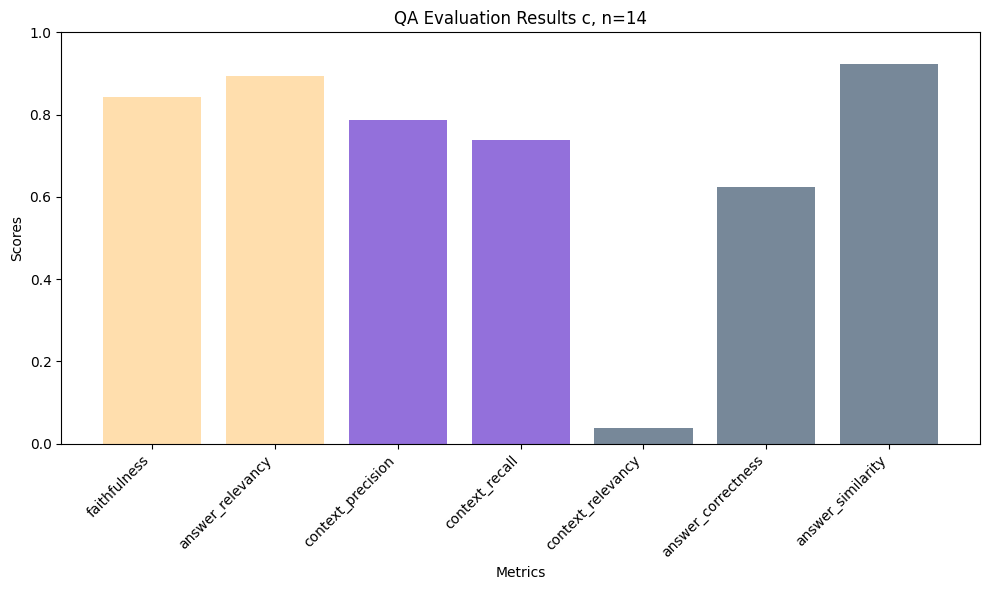

In [ ]:
# plot the result
import matplotlib.pyplot as plt

metrics = list(basic_qa_result.keys())
values = list(basic_qa_result.values())

colors = ['navajowhite', 'navajowhite',
          'mediumpurple', 'mediumpurple',
          'lightslategrey', 'lightslategrey', 'lightslategrey']

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('QA Evaluation Results c, n=14')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig('../data/plots/ragas_eval_c.png')
plt.show()

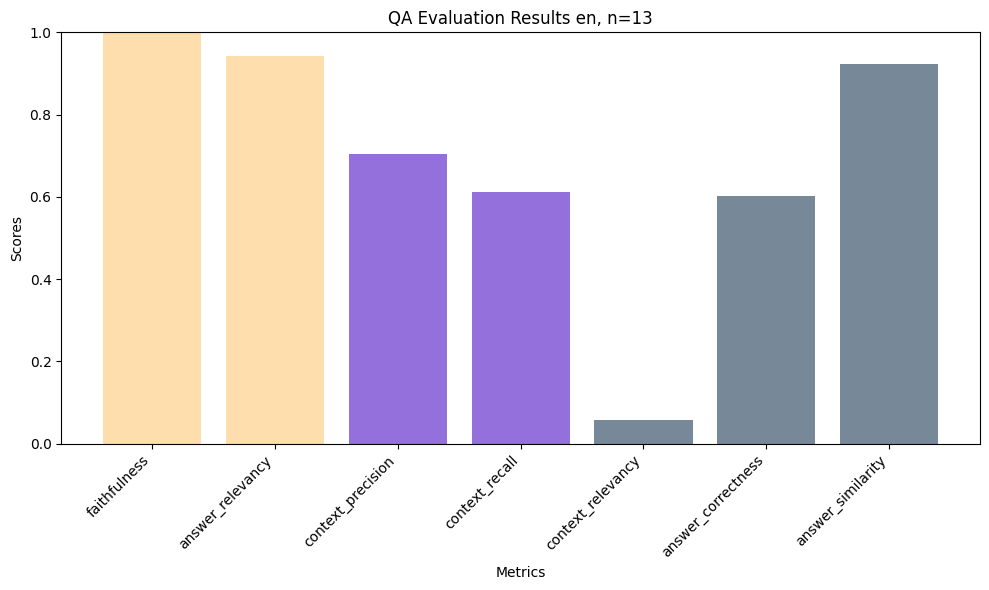

In [ ]:
# english results in same plot format
basic_qa_result_en = {
    'faithfulness': 1.0000,
    'answer_relevancy': 0.9414,
    'context_precision': 0.7051,
    'context_recall': 0.6117,
    'context_relevancy': 0.0584,
    'answer_correctness': 0.6032,
    'answer_similarity': 0.9219
}

metrics = list(basic_qa_result_en.keys())
values = list(basic_qa_result_en.values())

colors = ['navajowhite', 'navajowhite',
          'mediumpurple', 'mediumpurple',
          'lightslategrey', 'lightslategrey', 'lightslategrey']

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('QA Evaluation Results en, n=13')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig('../data/plots/ragas_eval_en.png')
plt.show()

In [ ]:
# calculate average for overview plot.
a = {
    'faithfulness': 0.8278,
    'answer_relevancy': 0.8531,
    'context_precision': 0.6667,
    'context_recall': 0.7857,
    'context_relevancy': 0.0193,
    'answer_correctness': 0.4075,
    'answer_similarity': 0.8521
}

b = {
    'faithfulness': 0.9583,
    'answer_relevancy': 0.7603,
    'context_precision': 0.7500,
    'context_recall': 0.8056,
    'context_relevancy': 0.0178,
    'answer_correctness': 0.6039,
    'answer_similarity': 0.8964
}

c = {
    'faithfulness': 0.9115,
    'answer_relevancy': 0.8881,
    'context_precision': 0.5873,
    'context_recall': 0.7857,
    'context_relevancy': 0.0344,
    'answer_correctness': 0.5637,
    'answer_similarity': 0.9286
}

keys = a.keys()
ragas_eval_mean = {}

for key in keys:
    ragas_eval_mean[key] = (a[key] + b[key] + c[key]) / 3

print(ragas_eval_mean)

{'faithfulness': 0.8992, 'answer_relevancy': 0.8338333333333333, 'context_precision': 0.668, 'context_recall': 0.7923333333333332, 'context_relevancy': 0.023833333333333335, 'answer_correctness': 0.5250333333333334, 'answer_similarity': 0.8923666666666666}


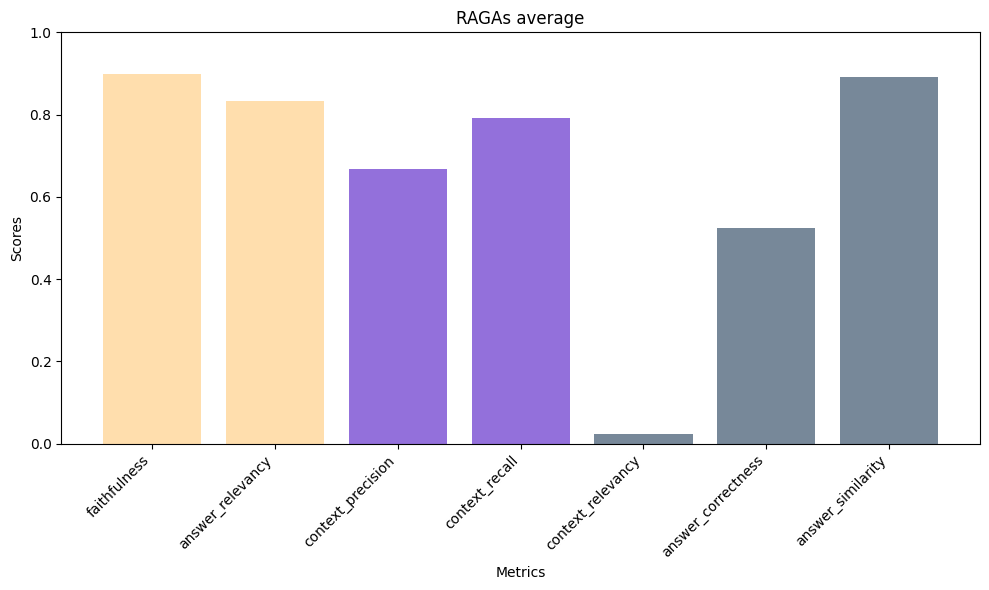

In [ ]:
metrics = list(ragas_eval_mean.keys())
values = list(ragas_eval_mean.values())

colors = ['navajowhite', 'navajowhite',
          'mediumpurple', 'mediumpurple',
          'lightslategrey', 'lightslategrey', 'lightslategrey']

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('RAGAs average')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig('../data/plots/ragas_eval_average.png')
plt.show()

In [ ]:
# show deviations
keys = a.keys()
ragas_eval_mean = {}

for key in keys:
    ragas_eval_mean[key] = (a[key] + b[key] + c[key]) / 3

deviations = {'a': {}, 'b': {}, 'c': {}}

for key in keys:
    deviations['a'][key] = a[key] - ragas_eval_mean[key]
    deviations['b'][key] = b[key] - ragas_eval_mean[key]
    deviations['c'][key] = c[key] - ragas_eval_mean[key]

print("Deviations in the german datasets:")
for key in keys:
    print(f"{key}:")
    print(f"  a: {deviations['a'][key]:+.4f}")
    print(f"  b: {deviations['b'][key]:+.4f}")
    print(f"  c: {deviations['c'][key]:+.4f}")


Deviations in the german datasets:
faithfulness:
  a: -0.0714
  b: +0.0591
  c: +0.0123
answer_relevancy:
  a: +0.0193
  b: -0.0735
  c: +0.0543
context_precision:
  a: -0.0013
  b: +0.0820
  c: -0.0807
context_recall:
  a: -0.0066
  b: +0.0133
  c: -0.0066
context_relevancy:
  a: -0.0045
  b: -0.0060
  c: +0.0106
answer_correctness:
  a: -0.1175
  b: +0.0789
  c: +0.0387
answer_similarity:
  a: -0.0403
  b: +0.0040
  c: +0.0362


In [ ]:
en = {
    'faithfulness': 1.0000,
    'context_precision': 0.7051,
    'answer_relevancy': 0.9414,
    'context_recall': 0.6117,
    'context_relevancy': 0.0584,
    'answer_correctness': 0.6032,
    'answer_similarity': 0.9219
}

en_deviations = {key: en[key] - ragas_eval_mean[key] for key in ragas_eval_mean.keys()}

# Print deviations
print("Deviations for the english dataset from the mean values:")
for key, value in en_deviations.items():
    print(f"{key}: {value:+.4f}")

Deviations for the english dataset from the mean values:
faithfulness: +0.1008
answer_relevancy: +0.1076
context_precision: +0.0371
context_recall: -0.1806
context_relevancy: +0.0346
answer_correctness: +0.0782
answer_similarity: +0.0295
